In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!unzip /content/brain-tumor-mri-dataset.zip

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import seaborn as sb

In [6]:
train_path = "/content/Training"
test_path = "/content/Testing"
batch_size = 64
image_size=(150, 150)

In [7]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
)
data_generator_test = ImageDataGenerator(
    rescale=1./255,
)

In [8]:
train_data = data_generator.flow_from_directory(
    train_path,
    batch_size=batch_size,
    target_size=image_size,
    shuffle=True
)
test_data = data_generator_test.flow_from_directory(
    test_path,
    batch_size=batch_size,
    target_size=image_size,
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [9]:
train_data.class_indices

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [10]:
names = ['glioma', 'meningioma', 'notumor', 'pituitary']

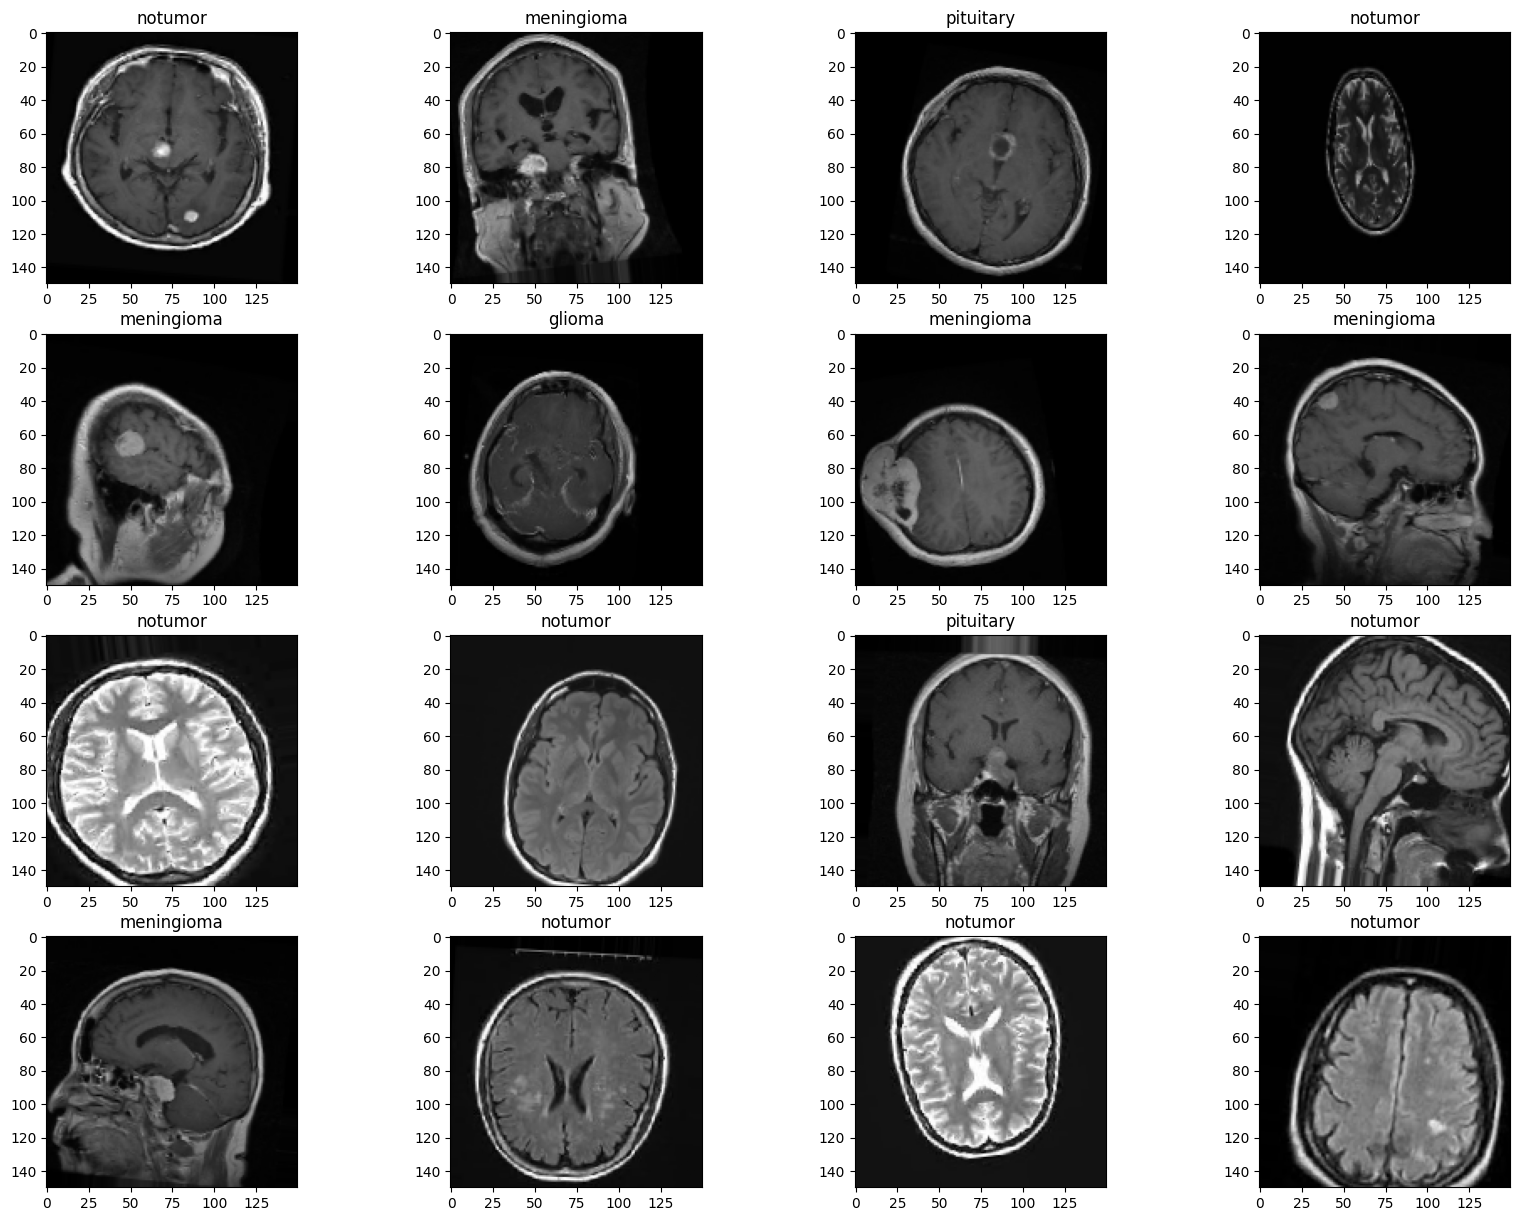

In [11]:
image, label = next(train_data)

plt.figure(figsize=(20, 15))
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(image[i])
  plt.title(names[label[i].argmax()])
plt.show()

In [29]:
model = keras.Sequential([
    keras.layers.Conv2D(64, 3, input_shape=(150, 150, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, 3),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, 3),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, 3),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, 3),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Flatten(),

    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(4, activation="softmax")

])

In [30]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 batch_normalization_36 (Ba  (None, 148, 148, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 74, 74, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 batch_normalization_37 (Ba  (None, 72, 72, 64)       

In [31]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
checkpoint = keras.callbacks.ModelCheckpoint("brain_tumor.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

In [32]:
history = model.fit(train_data, epochs=30, validation_data=test_data, callbacks=[early_stopping,checkpoint], batch_size=batch_size)

Epoch 1/30
90/90 [==============================] - ETA: 0s - loss: 0.9037 - accuracy: 0.6444
Epoch 1: val_accuracy improved from -inf to 0.30892, saving model to brain_tumor.keras
90/90 [==============================] - 46s 459ms/step - loss: 0.9037 - accuracy: 0.6444 - val_loss: 49.8635 - val_accuracy: 0.3089
Epoch 2/30
90/90 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.7803
Epoch 2: val_accuracy improved from 0.30892 to 0.48970, saving model to brain_tumor.keras
90/90 [==============================] - 42s 462ms/step - loss: 0.6030 - accuracy: 0.7803 - val_loss: 2.5341 - val_accuracy: 0.4897
Epoch 3/30
90/90 [==============================] - ETA: 0s - loss: 0.5075 - accuracy: 0.8136
Epoch 3: val_accuracy improved from 0.48970 to 0.58734, saving model to brain_tumor.keras
90/90 [==============================] - 42s 463ms/step - loss: 0.5075 - accuracy: 0.8136 - val_loss: 1.0619 - val_accuracy: 0.5873
Epoch 4/30
90/90 [==============================] - ET

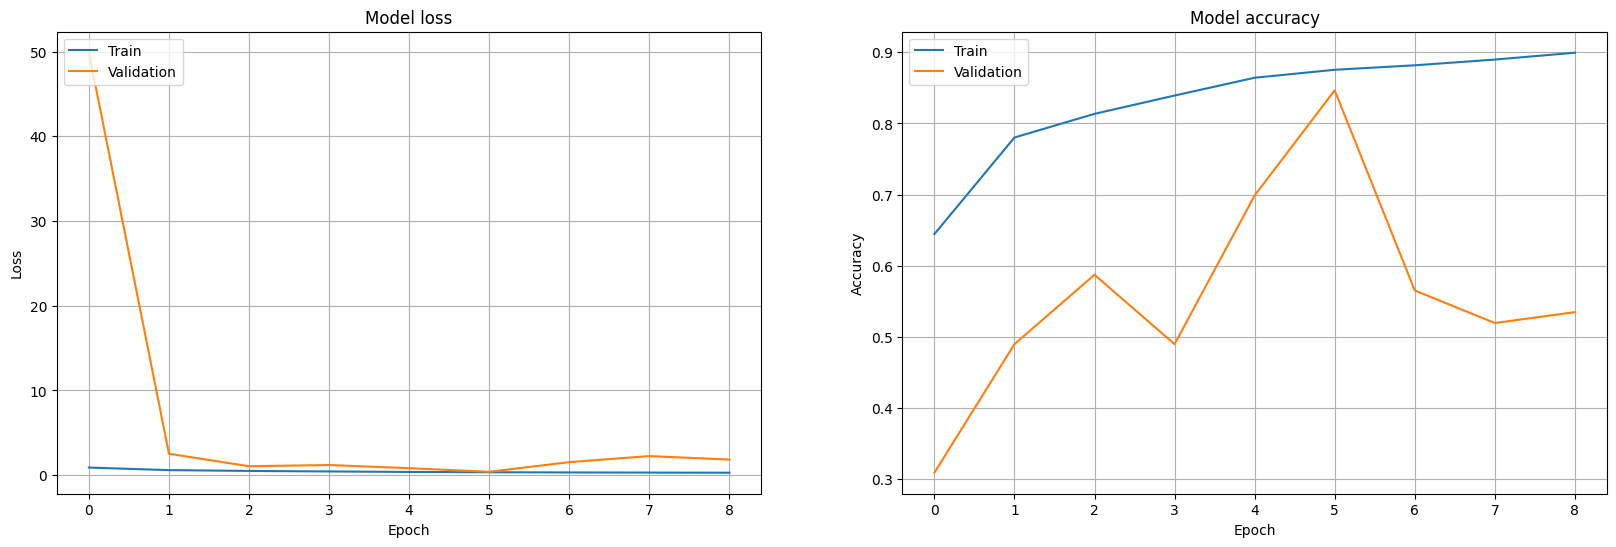

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_title('Model loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper left')
ax[0].grid(True)

ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_title('Model accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='upper left')
ax[1].grid(True)
plt.show()

In [34]:
loaded_model = keras.models.load_model('brain_tumor.keras')

In [36]:
loaded_model.evaluate(test_data)

21/21 [==============================] - 3s 106ms/step - loss: 0.4073 - accuracy: 0.8467


[0.40733736753463745, 0.8466818928718567]